# Clasificación de Congestión en Redes SDN usando Machine Learning
Este notebook contiene el flujo completo de carga, preprocesamiento, análisis y modelado de datos para clasificar niveles de congestión en redes definidas por software (SDN).

#Carga de Datos 📁

Se cargan los datasets necesarios para el análisis.

### Subir archivos

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset_f_con.csv to dataset_f_con.csv


### Cargar archivos con pandas

Cambiar libreria de scikit learn para comptabilidad con el controlador SDN

In [1]:
pip install scikit-learn==1.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 73.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.3.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
cuml-cu12 25.6.0 requires scikit-

In [ ]:
import pandas as pd
# Definir nombres de las columnas según la estructura de la base de datos
column_names = ["timestamp", "dpid", "port", "throughput_mbps", "utilization_pct",
                "avg_pkt_size_rx", "avg_pkt_size_tx", "throughput_jitter", "delay",
                "jitter", "d_utilization", "d_throughput", "tx_bytes", "rx_bytes", "test_scenario"]

df1 = pd.read_csv('dataset_f_con.csv',names=column_names)

df1.head()

,timestamp,dpid,port,throughput_mbps,utilization_pct,avg_pkt_size_rx,avg_pkt_size_tx,throughput_jitter,delay,jitter,d_utilization,d_throughput,tx_bytes,rx_bytes,test_scenario
1,1.741499e+09,63993884303947,2,22.3271,3.66019,1506.2400,65.9956,8.33590,-1.000000,-1.000000,3.26892,19.940400,173749061,8507780120,Sin-Congestion
2,1.741499e+09,63993884303947,3,22.6547,3.71388,65.9956,1505.5600,8.46736,0.008530,0.000095,3.37568,20.591700,8507811142,173747679,Sin-Congestion
3,1.741499e+09,222777563905866,1,21.9322,3.59545,1504.7600,65.9956,8.19541,0.007148,0.002073,3.15322,19.234600,173747679,8507810170,Sin-Congestion
4,1.741499e+09,222777563905866,3,21.9313,3.59529,66.0000,1505.5600,8.19521,-1.000000,-1.000000,3.15315,19.234200,7853032217,159806303,Sin-Congestion
5,1.741499e+09,222777563905866,1,21.8979,3.58981,1506.3500,65.9901,10.01040,0.052477,0.045329,-0.00583,-0.035564,173787603,8510414652,Sin-Congestion


## 🔍 Exploración Inicial de Datos

Visualizamos los escenarios de congestión en el dataset.

In [ ]:
df1['test_scenario'].value_counts()

,count
test_scenario,
Congestion Progresiva-TREE,11662
Sin Congestion-TREE,4352
Congestion-Progresiva,3889
Congestion Moderada-TREE,2914
Congestion Severa-TREE,2180
Sin-Congestion,1443
Congestion-Moderada,976
Congestion-Severa,728


### Definir escenarios de congestión

In [ ]:
import pandas as pd
# Definir los escenarios de congestión excluyendo 'Congestion Progresiva'
scenarios = [
    "Sin Congestion-TREE", "Sin-Congestion",
    "Congestion Moderada-TREE", "Congestion-Moderada",
    "Congestion Severa-TREE", "Congestion-Severa"
]

# Filtrar filas con delay -1 (casos host-switch)
df1 = df1[df1["delay"] != -1]
# Filtrar solo los escenarios seleccionados
df_filtered = df1[df1["test_scenario"].isin(scenarios)]
# **Seleccionar solo ciertas métricas para análisis**
selected_metrics = ["utilization_pct", "delay", "jitter", "throughput_jitter"]
# Estadísticas descriptivas
stats = df_filtered.groupby("test_scenario")[selected_metrics].agg(['mean', 'std', 'min', 'max'])
stats



utilization_pct                                \
                                    mean        std      min       max   
test_scenario                                                            
Congestion Moderada-TREE       82.939033  10.882020  3.13246  100.0000   
Congestion Severa-TREE         93.643292  10.187948  5.87932  100.0000   
Congestion-Moderada            81.975819  10.916630  3.69360  100.0000   
Congestion-Severa              97.310599   9.841650  7.46523  100.0000   
Sin Congestion-TREE            28.023583  19.883467  3.01194   66.2382   
Sin-Congestion                 28.187535  19.806018  3.06457   63.1466   

                             delay                                  jitter  \
                              mean       std       min       max      mean   
test_scenario                                                                
Congestion Moderada-TREE  0.071475  0.039995  0.002487  0.382925  0.023611   
Congestion Severa-TREE    0.070121  0.031396  0.002172  0.321720  0.020219   
Congestion-Moderada       0.049237  0.022041  0.005852  0.247297  0.014972   
Congestion-Severa         0.058117  0.034366  0.001451  0.366178  0.019830   
Sin Congestion-TREE       0.061441  0.026269  0.002075  0.275905  0.015057   
Sin-Congestion            0.048552  0.019383  0.002342  0.226332  0.012454   

                                                           throughput_jitter  \
                               std           min       max              mean   
test_scenario                                                                  
Congestion Moderada-TREE  0.045255  1.907350e-06  0.335266         56.385663   
Congestion Severa-TREE    0.034203  7.152560e-07  0.279566         75.871310   
Congestion-Moderada       0.025162  6.437300e-06  0.193359         54.625948   
Congestion-Severa         0.040586  9.298320e-06  0.316855         71.216416   
Sin Congestion-TREE       0.028921  5.245210e-06  0.226924         17.004934   
Sin-Congestion            0.023485  1.144410e-05  0.198464         15.404763   

                                                        
                                std       min      max  
test_scenario                                           
Congestion Moderada-TREE  75.486554  2.969720  273.714  
Congestion Severa-TREE    83.565618  7.213670  325.610  
Congestion-Moderada       75.557576  4.807100  242.064  
Congestion-Severa         93.154522  7.556480  347.267  
Sin Congestion-TREE       32.180790  0.306654  176.373  
Sin-Congestion            30.724789  0.264395  156.669

### Etiquetado de Congestión

In [ ]:
# Definir función para etiquetar cada fila según los umbrales establecidos
def label_congestion(fila):
    if fila["delay"] == -1:  # Eliminar datos no medidos entre switches
        return -1

    # Umbrales (percentiles ajustados)
    UMBRAL_UTIL_SIN = 63.15  # Max Sin-Congestion
    UMBRAL_UTIL_SEV = 90.00  # Promedio Congestion-Severa: 97.31
    UMBRAL_DELAY = 0.23      # Max Sin-Congestion
    UMBRAL_JITTER = 0.20     # Max Congestion-Moderada
    UMBRAL_THR_JITTER = 156.67  # Max Sin-Congestion

    # Lógica de decisión
    if (fila['utilization_pct'] <= UMBRAL_UTIL_SIN and
        fila['delay'] <= UMBRAL_DELAY and
        fila['jitter'] <= UMBRAL_JITTER and
        fila['throughput_jitter'] <= UMBRAL_THR_JITTER):
        return 0  # Sin congestión

    else:
        return 1  # Fusionamos moderada con severa como "Congestión"
    """
    #Opcion mezclar
    # Umbrales (percentiles ajustados)
    UMBRAL_UTIL_SIN = 63.15  # Max Sin-Congestion
    UMBRAL_UTIL_SEV = 90.00  # Promedio Congestion-Severa: 97.31
    UMBRAL_DELAY = 0.23      # Max Sin-Congestion
    UMBRAL_JITTER = 0.20     # Max Congestion-Moderada
    UMBRAL_THR_JITTER = 156.67  # Max Sin-Congestion

    # Lógica de decisión
    if (fila['utilization_pct'] <= UMBRAL_UTIL_SIN and
        fila['delay'] <= UMBRAL_DELAY and
        fila['jitter'] <= UMBRAL_JITTER and
        fila['throughput_jitter'] <= UMBRAL_THR_JITTER):
        return 0  # Sin congestión

    elif (fila['utilization_pct'] > UMBRAL_UTIL_SEV or
          fila['delay'] > 0.35 or  # 90% percentil Congestion-Severa
          fila['jitter'] > 0.30 or
          fila['throughput_jitter'] > 300):
        return 1  # Congestión

    else:
        return 0  # Fusionamos la clase moderada con "No congestión"
"""
# Aplicar la función al dataset
df1["label"] = df1.apply(label_congestion, axis=1)
# Verificar si "label" está en el dataset
if "label" in df1.columns:
    df3 = df1[selected_metrics + ["label"]].copy()
else:
    df3 = df1[selected_metrics].copy()


df3.agg(['min','max'])

,utilization_pct,delay,jitter,throughput_jitter,label
min,3.00692,0.001451,4.768370e-07,0.194651,0
max,100.00000,0.450061,3.924450e-01,347.267000,1




```
# Tiene formato de código
```

## ⚙️ Preprocesamiento y entranamiento de Datos

Incluye normalización, tratamiento de valores nulos, y separación de características.

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# **Seleccionar solo ciertas métricas para análisis**
selected_metrics = ["utilization_pct", "delay", "jitter", "throughput_jitter"]

def inspeccion_datos(df):
    """Muestra las primeras filas y la información del dataframe."""
    print("Primeras filas del dataset:")
    print(df.head())
    print("\nInformación del dataset:")
    print(df.info())
    print("\nEstadísticas descriptivas del dataset:")
    print(df.describe())

def manejar_valores_nulos_y_infinitos(df):
    """Reemplaza valores nulos e infinitos en el DataFrame."""
    # Reemplazar infinitos con NaN
    df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)

    # Imputar valores nulos con la media
    imputer = SimpleImputer(strategy='mean')
    df[selected_metrics] = imputer.fit_transform(df[selected_metrics])

    return df

def normalize_data(df, columns):
    """Normaliza las columnas especificadas usando MinMaxScaler."""
    scaler = MinMaxScaler(feature_range=(0, 1))
    df[columns] = scaler.fit_transform(df[columns])
    return df, scaler

def preprocess_data(df):
    """Realiza el preprocesamiento completo del DataFrame."""
    print("Iniciando preprocesamiento de datos...")

    # Manejar valores nulos e infinitos
    df2 = manejar_valores_nulos_y_infinitos(df)

    # Normalizar las columnas seleccionadas y obtener el escalador
    df2, scaler = normalize_data(df, selected_metrics)

    print("Preprocesamiento completado.")
    return df2, scaler



In [ ]:
df_new,scaler=preprocess_data(df3)
# Coloque los __DataFrames__ de lado a lado
df3.describe()

Iniciando preprocesamiento de datos...
Preprocesamiento completado.


,utilization_pct,delay,jitter,throughput_jitter,label
count,14072.000000,14072.000000,14072.000000,14072.000000,14072.000000
mean,0.612752,0.138345,0.046847,0.131408,0.558485
std,0.329335,0.070649,0.088442,0.196198,0.496585
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.329684,0.102076,0.007944,0.020054,0.000000
50%,0.718005,0.125684,0.018282,0.048836,1.000000
75%,0.896041,0.164170,0.047225,0.145520,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df3.headd()

,utilization_pct,delay,jitter,throughput_jitter,label
2,0.007289,0.015780,0.000241,0.023836,0
3,0.006068,0.012700,0.005281,0.023052,0
5,0.006010,0.113742,0.115502,0.028282,0
8,0.003741,0.115139,0.113577,0.027915,0
10,0.005662,0.110219,0.005623,0.030206,0


In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from sklearn.model_selection import train_test_split
import sys

from collections import Counter

def balancear_clases(X, y, metodo):
    """
    Aplica oversampling, undersampling o una combinación (SMOTE + Tomek) según el método seleccionado.

    Parámetros:
        - X: Características del dataset.
        - y: Etiqueta de clasificación.
        - metodo: "oversampling", "undersampling" o "smote_tomek".

    Retorna:
        - X_resampled, y_resampled: Dataset balanceado.
    """
    print("\nDistribución previa a balanceo:")
    print(y.value_counts())
    if metodo == "oversampling":
        sampler = RandomOverSampler(random_state=42)
        print("\n🔹 Aplicando **Oversampling**...")
    elif metodo == "undersampling":
        sampler = RandomUnderSampler(random_state=42)
        print("\n🔹 Aplicando **Undersampling**...")
    elif metodo == "smote_tomek":
        print("\n🔹 Aplicando **SMOTE + Tomek Links**...")

        # Aplicar SMOTE primero
        smote = SMOTE(random_state=42)
        X_smote, y_smote = smote.fit_resample(X, y)
        print(f"📊 **Después de SMOTE:** {Counter(y_smote)}")

        # Aplicar Tomek Links
        tomek = TomekLinks()
        X_resampled, y_resampled = tomek.fit_resample(X_smote, y_smote)
        print(f"📊 **Después de Tomek Links:** {Counter(y_resampled)}")

        # Verificar si aún hay al menos dos clases después del balanceo
        if len(set(y_resampled)) < 2:
            print("⚠ **Advertencia:** Solo queda una clase después del balanceo. Revisa la estrategia.")
            return X, y  # Devuelve los datos originales

        return X_resampled, y_resampled

    else:
        raise ValueError("Método inválido. Usa 'oversampling', 'undersampling' o 'smote_tomek'.")

    # Aplicar balanceo
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    print(f"📊 **Distribución después del balanceo:** {Counter(y_resampled)}")

    # Verificar si aún hay al menos dos clases después del balanceo
    if len(set(y_resampled)) < 2:
        print("**Advertencia:** Solo queda una clase después del balanceo. Revisa la estrategia.")
        return X, y  # Devuelve los datos originales

    return X_resampled, y_resampled

# Paso 6: Dividir el dataset en características (X) y etiquetas (y)
def dividir_datos(df, columna_etiqueta,metodo_balanceo):
    """
    Divide el dataset en características (X) y etiquetas (y) y aplica oversampling.
    """
    X = df.drop(columns=[columna_etiqueta])  # Características (sin la columna de la etiqueta)
    y = df[columna_etiqueta]  # Etiqueta

    # Mostrar distribución antes del oversampling
    #    print("Distribución previa a oversampling:")
    #print(y.value_counts())

    X_resampled,y_resampled=balancear_clases(X,y,metodo_balanceo)

    # Mostrar distribución después del oversampling
    #print("Distribución después de oversampling:")
    #print(y_resampled.value_counts())

    return X_resampled, y_resampled

# Paso 7: Dividir en conjuntos de entrenamiento y prueba
def dividir_entrenamiento_y_prueba(X, y, test_size=0.2):
    """
    Divide el dataset en conjunto de entrenamiento y conjunto de prueba.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    print(f"Tamaño de X_train: {X_train.shape}")
    print(f"Tamaño de X_test: {X_test.shape}")
    return X_train, X_test, y_train, y_test


def DIVISION(dataframeprep,columna_etiqueta,metodo):
    # Dividir en características (X) y etiquetas (y)
    X,y= dividir_datos(dataframeprep, columna_etiqueta,metodo)
    # Dividir en entrenamiento y prueba
    X_train, X_test, y_train, y_test = dividir_entrenamiento_y_prueba(X, y)

    return X_train, X_test, y_train, y_test


**Division de datos entrenamiento/testeo**

In [ ]:
df3.head()
columna_etiqueta = "label"
X_train, X_test, y_train, y_test=DIVISION(df3,columna_etiqueta,"smote_tomek")
#warnings.filterwarnings("ignore", category=FutureWarning)


Distribución previa a balanceo:
label
1    7859
0    6213
Name: count, dtype: int64

🔹 Aplicando **SMOTE + Tomek Links**...
📊 **Después de SMOTE:** Counter({0: 7859, 1: 7859})
📊 **Después de Tomek Links:** Counter({0: 7859, 1: 7852})
Tamaño de X_train: (12568, 4)
Tamaño de X_test: (3143, 4)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def entrenar_random_forest_con_grid_search(X_train, y_train):
    """
    Entrena un modelo de Random Forest utilizando GridSearch para optimizar los hiperparámetros.

    Args:
        X_train: Características del conjunto de entrenamiento.
        y_train: Etiquetas del conjunto de entrenamiento.

    Returns:
        Mejor modelo entrenado y resultados de GridSearch.
    """
    # Definir el rango de hiperparámetros para GridSearch
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'class_weight': ['balanced']
    }

    print("Buscando los mejores hiperparámetros con GridSearch...")
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, n_jobs=1)
    grid_search.fit(X_train, y_train)

    print("Mejores hiperparámetros encontrados:")
    print(grid_search.best_params_)
    print("Entrenamiento Completado :D")
    print("Vuelva Pronto :D")

    return grid_search.best_estimator_, grid_search


"""
Entrena y evalúa un modelo de Random Forest utilizando GridSearch para optimización de hiperparámetros.
"""
print("Entrenando el modelo Random Forest con GridSearch...")
modelo, grid_search = entrenar_random_forest_con_grid_search(X_train, y_train)


Entrenando el modelo Random Forest con GridSearch...
Buscando los mejores hiperparámetros con GridSearch...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Entrenar el modelo con mejores hiperparametros
#{'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

def entrenar_random_forest(X_train, y_train):
    """
    Entrena un modelo de Random Forest con los datos de entrenamiento.

    Parámetros:
        - X_train: Características del conjunto de entrenamiento.
        - y_train: Etiquetas del conjunto de entrenamiento.
        - n_estimators: Número de árboles en el bosque (por defecto 100).
        - max_depth: Profundidad máxima de los árboles (None para sin límite).
    """
    modelo = RandomForestClassifier(
    class_weight='balanced',
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=100,
    random_state=42
    )
    modelo.fit(X_train, y_train)
    print("Entrenamiento Completado :D")
    print("Vuelva Pronto :D")
    return modelo
# Main
def main_random_forest(X_train, X_test, y_train, y_test):
    """
    Entrena y evalúa un modelo de Random Forest.
    """
    print("Entrenando el modelo Random Forest...")
    modelo = entrenar_random_forest(X_train, y_train)
    return modelo
# Llamada al flujo
modelo=main_random_forest(X_train, X_test, y_train, y_test)

Entrenando el modelo Random Forest...
Entrenamiento Completado :D
Vuelva Pronto :D


**Evaluacion del Modelo Random Forest**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def evaluar_modelo(modelo, X_test, y_test):
    """
    Evalúa el modelo y muestra resultados.
    """
    print("Evaluando el modelo...")
    y_pred = modelo.predict(X_test)

    # Reporte de métricas
    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))

    # Matriz de confusión
    print("\nMatriz de Confusión:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Congestion", "Congestion"],
                yticklabels=["No Congestion", "Congestion"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Matriz de Confusión")
    plt.show()

Evaluando el modelo...

Accuracy: 1.0

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1572
           1       1.00      1.00      1.00      1571

    accuracy                           1.00      3143
   macro avg       1.00      1.00      1.00      3143
weighted avg       1.00      1.00      1.00      3143


Matriz de Confusión:


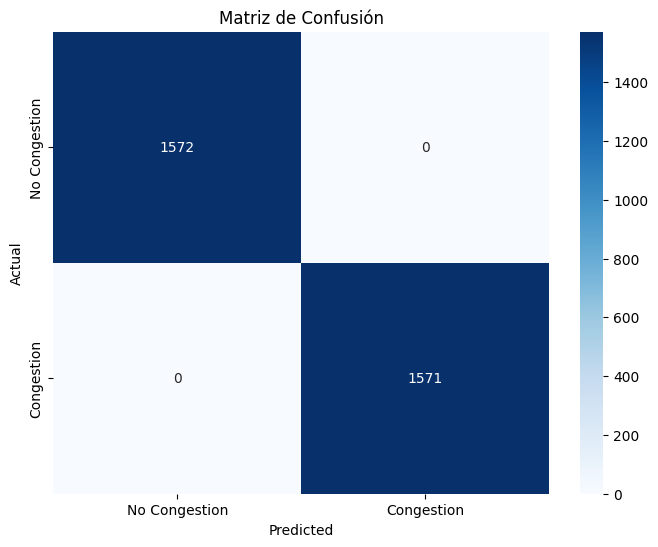

In [ ]:
evaluar_modelo(modelo,X_test,y_test)


--- Conjunto de Entrenamiento ---
Accuracy en entrenamiento: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6287
           1       1.00      1.00      1.00      6281

    accuracy                           1.00     12568
   macro avg       1.00      1.00      1.00     12568
weighted avg       1.00      1.00      1.00     12568


--- Conjunto de Prueba ---
Accuracy en prueba: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1572
           1       1.00      1.00      1.00      1571

    accuracy                           1.00      3143
   macro avg       1.00      1.00      1.00      3143
weighted avg       1.00      1.00      1.00      3143


--- Resumen ---
Diferencia entre entrenamiento y prueba: 0.00%


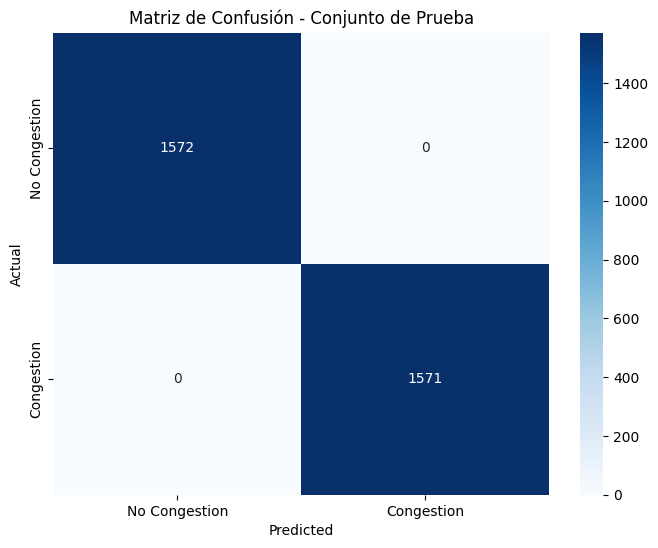

In [ ]:
def evaluar_sobreentrenamiento(modelo, X_train, y_train, X_test, y_test):
    """
    Evalúa el modelo en entrenamiento y prueba para detectar sobreentrenamiento.

    Args:
        modelo: Modelo entrenado.
        X_train, y_train: Conjunto de entrenamiento.
        X_test, y_test: Conjunto de prueba.
    """
    # Evaluar en el conjunto de entrenamiento
    y_train_pred = modelo.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print("\n--- Conjunto de Entrenamiento ---")
    print(f"Accuracy en entrenamiento: {train_accuracy}")
    print(classification_report(y_train, y_train_pred))

    # Evaluar en el conjunto de prueba
    y_test_pred = modelo.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print("\n--- Conjunto de Prueba ---")
    print(f"Accuracy en prueba: {test_accuracy}")
    print(classification_report(y_test, y_test_pred))

    # Comparar los resultados
    print("\n--- Resumen ---")
    print(f"Diferencia entre entrenamiento y prueba: {train_accuracy - test_accuracy:.2%}")

    # Visualizar matriz de confusión en prueba
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Congestion", "Congestion"],
                yticklabels=["No Congestion", "Congestion"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Matriz de Confusión - Conjunto de Prueba")
    plt.show()
evaluar_sobreentrenamiento(modelo, X_train, y_train, X_test, y_test)

***Comparacion con Modelo KNN***

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score


def entrenar_knn(X_train, y_train):
    """
    Entrena un modelo KNN utilizando GridSearch para optimizar los hiperparámetros.

    Args:
        X_train: Características del conjunto de entrenamiento.
        y_train: Etiquetas del conjunto de entrenamiento.

    Returns:
        Mejor modelo entrenado y resultados de GridSearch.
    """
    # Definir el rango de hiperparámetros para KNN
    param_grid = {
        'n_neighbors': [3, 5, 7, 10],  # Número de vecinos
        'weights': ['uniform', 'distance'],  # Tipo de ponderación
        'p': [1, 2]  # Distancia: Manhattan (1) o Euclidiana (2)
    }

    print("Buscando los mejores hiperparámetros con GridSearch para KNN...")
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    results = grid_search.cv_results_
    plt.plot(param_grid['n_neighbors'], results['mean_test_score'][:len(param_grid['n_neighbors'])], marker='o')
    plt.xlabel("Número de Vecinos (k)")
    plt.ylabel("Precisión Promedio")
    plt.title("Impacto del Número de Vecinos en el Rendimiento de KNN")
    plt.show()

    print("Mejores hiperparámetros encontrados para KNN:")
    print(grid_search.best_params_)

    return grid_search.best_estimator_, grid_search

def evaluar_knn(modelo, X_test, y_test):
    """
    Evalúa el modelo KNN y muestra resultados.
    """
    y_pred = modelo.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"\nF1 Score (Weighted): {f1:.4f}")
    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    print("\nMatriz de Confusión:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    class_labels = sorted(set(y_test))  # Extrae las clases del test set
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["No Congestion", "Congestion"], yticklabels=["No Congestion", "Congestion"])
    plt.xlabel("Prediccion")
    plt.ylabel("Actual")
    plt.title("Matriz de Confusión - KNN")
    plt.show()






In [ ]:
# Entrenamiento y evaluación de KNN
modelo_knn, grid_knn = entrenar_knn(X_train, y_train)
evaluar_knn(modelo_knn, X_test, y_test)

SyntaxError: '[' was never closed (<ipython-input-27-b841b4023394>, line 1)


F1 Score (Weighted): 0.9990

Accuracy: 0.9990454979319122

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1572
           1       1.00      1.00      1.00      1571

    accuracy                           1.00      3143
   macro avg       1.00      1.00      1.00      3143
weighted avg       1.00      1.00      1.00      3143


Matriz de Confusión:


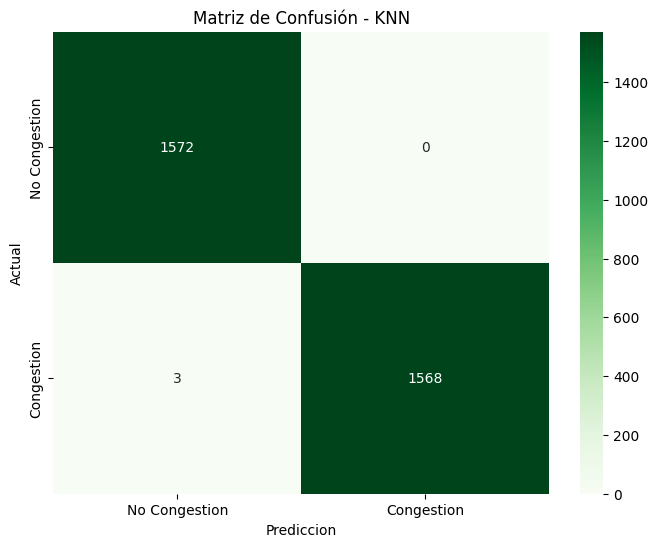

In [ ]:
evaluar_knn(modelo_knn, X_test, y_test)d

*Comparativa con modelo implementando regresion logistica*

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

def train_logistic_with_gridsearch(X_train, y_train):
    """
    Busca los mejores hiperparámetros usando GridSearchCV y entrena el mejor modelo.
    """
    param_grid = {
        'C': [0.01, 0.1, 1, 10],
        'max_iter': [100, 300, 500, 1000],
        'class_weight': [None, 'balanced'],
        'solver': ['lbfgs']
    }

    grid = GridSearchCV(
        LogisticRegression(),
        param_grid,
        cv=5,  # validación cruzada con 5 folds
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    print("Mejor combinación encontrada:", grid.best_params_)
    print("Mejor accuracy promedio (CV):", grid.best_score_)
    return grid.best_estimator_

def train_logistic_model(X_train,y_train, use_grid_search=True):
    """
    Entrena un modelo de regresión logística binaria, con opción a optimización por GridSearch.
    """
    if use_grid_search:
        model = train_logistic_with_gridsearch(X_train, y_train)
    else:
        model = LogisticRegression(max_iter=1000, class_weight='balanced')
        model.fit(X_train, y_train)

    return model

def evaluate_model(model, X_test, y_test):
    """
    Evalúa un modelo entrenado de clasificación binaria.
    Imprime accuracy, matriz de confusión y reporte de clasificación.
    """
    y_pred = model.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                xticklabels=['Sin Congestión', 'Congestión'],
                yticklabels=['Sin Congestión', 'Congestión'])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión - Regresión Logística")
    plt.show()




Fitting 5 folds for each of 32 candidates, totalling 160 fits
✅ Mejor combinación encontrada: {'C': 0.1, 'class_weight': None, 'max_iter': 100, 'solver': 'lbfgs'}
📈 Mejor accuracy promedio (CV): 0.9823361163160792
🔎 Accuracy: 0.9825007954183901

📊 Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1572
           1       0.98      0.98      0.98      1571

    accuracy                           0.98      3143
   macro avg       0.98      0.98      0.98      3143
weighted avg       0.98      0.98      0.98      3143



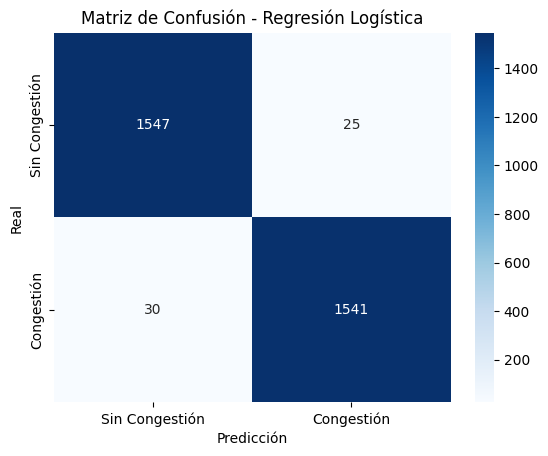

In [ ]:
# Entrenamiento y evaluación de XGBoost
modelo_rl=train_logistic_model(X_train, y_train)
evaluate_model(modelo_rl, X_test, y_test)

Accuracy: 0.9825007954183901

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1572
           1       0.98      0.98      0.98      1571

    accuracy                           0.98      3143
   macro avg       0.98      0.98      0.98      3143
weighted avg       0.98      0.98      0.98      3143



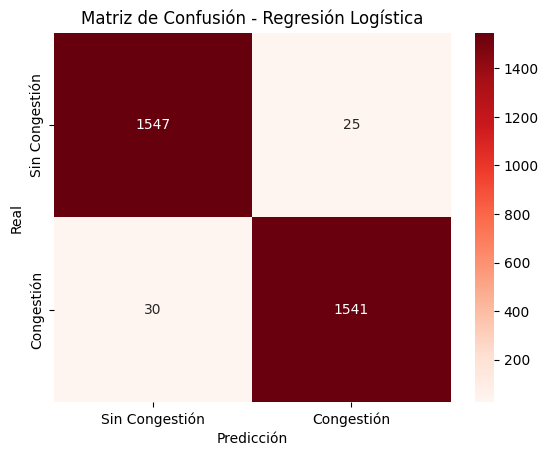

In [ ]:
evaluate_model(modelo_rl, X_test, y_test)

***Exportar Modelos***

In [ ]:
import pickle
import joblib


from google.colab import files
# Supongamos que 'model' es tu modelo entrenado
with open('modelo_rf.pkl', 'wb') as f:
  pickle.dump(modelo, f)
files.download('modelo_rf.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# Guardar el escalador entrenado en un archivo
joblib.dump(scaler, "scaler.pkl")

# Descargar el archivo .pkl

files.download('scaler.pkl')

In [ ]:
from google.colab import files
# Supongamos que 'model' es tu modelo entrenado
with open('modelo_knn.pkl', 'wb') as f:
  pickle.dump(modelo_knn, f)
files.download('modelo_knn.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
# Supongamos que 'model' es tu modelo entrenado
with open('modelo_rl.pkl', 'wb') as f:
  pickle.dump(modelo_rl, f)
files.download('modelo_rl.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import sklearn
print(f"Versión actual de scikit-learn: {sklearn.__version__}")

Versión actual de scikit-learn: 1.3.2


In [ ]:
print(f"Número de características esperadas por el modelo: {modelo.n_features_in_}")
import joblib
import sklearn
print(f"Versión de scikit-learn utilizada en el modelo: {modelo.__getstate__()['_sklearn_version']}")



Número de características esperadas por el modelo: 4
Versión de scikit-learn utilizada en el modelo: 1.3.2
